# Object Detection Workflow with `arcgis.learn`
 
Deep learning models 'learn' by looking at several examples of imagery and the expected outputs. In the case of object detection, this requires imagery as well as known or labelled locations of objects that the model can learn from. With the ArcGIS platform, these datasets are represented as layers, and are available in our GIS. In the workflow below, we will be training a model to identify well pads from Planet imagery.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Export-Training-Samples" data-toc-modified-id="Export-Training-Samples-1">Export Training Samples</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-2">Data Preparation</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-3">Model Training</a></span><ul class="toc-item"><li><span><a href="#Train-SingleShotDetector-Model" data-toc-modified-id="Train-SingleShotDetector-Model-3.1">Train SingleShotDetector Model</a></span></li><li><span><a href="#Find-the-good-learning-rate" data-toc-modified-id="Find-the-good-learning-rate-3.2">Find the good learning rate</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3.3">Train the model</a></span></li><li><span><a href="#Unfreezing-the-backbone-and-fine-tuning" data-toc-modified-id="Unfreezing-the-backbone-and-fine-tuning-3.4">Unfreezing the backbone and fine-tuning</a></span></li><li><span><a href="#Visualize-results" data-toc-modified-id="Visualize-results-3.5">Visualize results</a></span></li><li><span><a href="#Save-and-load-trained-models" data-toc-modified-id="Save-and-load-trained-models-3.6">Save and load trained models</a></span></li></ul></li><li><span><a href="#Deploy-trained-model" data-toc-modified-id="Deploy-trained-model-4">Deploy trained model</a></span></li><li><span><a href="#Model-management" data-toc-modified-id="Model-management-5">Model management</a></span></li><li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-6">Model inference</a></span><ul class="toc-item"><li><span><a href="#Visualize-results" data-toc-modified-id="Visualize-results-6.1">Visualize results</a></span></li></ul></li></ul></div>

The code below connects to our GIS and accesses the known well pad locations and the imagery, in this case provided by Planet:

In [1]:
from arcgis.gis import GIS
from arcgis.raster.functions import extract_band 
from arcgis.learn import export_training_data

gis = GIS("home")

<Item title:"Well Pads Permian Basin" type:Feature Layer Collection owner:portaladmin>
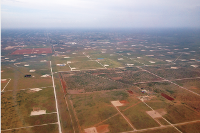

In [2]:
# layers we need - The input to generate training samples and the imagery
well_pads = gis.content.get('ae6f1c62027c42b8a88c4cf5deb86bbf') # Well pads layer
well_pads

In [3]:
# Weekly mosaics provided by Planet
planet_mosaic_item = gis.content.search("PlanetGlobalMosaics")[0] 
planet_mosaic_item

<Item title:"PlanetGlobalMosaics" type:Imagery Layer owner:portaladmin>

## Export Training Samples

The `export_training_data()` method generates training samples for training deep learning models, given the input imagery, alongwith labeled vector data or classified images. Deep learning training samples are small subimages, called image chips, and contain the feature or class of interest. This tool creates folders containing image chips for training the model, labels and metadata files and stores them in the raster store of your enterprise GIS. The image chips are often small (e.g. 256x256), unless the training sample size is large. These training samples support model training workflows using the `arcgis.learn` package as well as by third-party deep learning libraies, such as TensorFlow or PyTorch. The supported models in `arcgis.learn` accept the **[PASCAL_VOC_rectangles](http://host.robots.ox.ac.uk/pascal/VOC/databases.html)** format for object detection models, a standardized image dataset for object class recognition. The label files are XML files containing information about image name, class value, and bounding boxes.

In order to take advantage of pretrained models that have been trained on large image collections (e.g. ImageNet), we have to pick 3 bands from a multispectral imagery as those pretrained models are trained with images that have only 3 RGB channels. The `extract_bands()` method can be used to specify which 3 bands should be extracted for fine tuning the models:

In [4]:
planet_mosaic_data = extract_band(planet_mosaic_item.layers[0], [1,2,3])

We recommend exporting image chips with a larger size than that used for training the models. This allows `arcgis.learn` to perform random center cropping as part of its default data augmentation and makes the model see a different sub-area of each chip when training leading to better generalization and avoid overfitting to the training data. By default, a chip size of 448 x 448 pixels works well, but this can be adjusted based on the amount of context you wish to provide to the model, as well as the amount of GPU memory available.

In [8]:
chips = export_training_data(planet_mosaic_data, well_pads, "PNG", {"x":448,"y":448}, {"x":224,"y":224}, 
                             "PASCAL_VOC_rectangles", 75, "planetdemo")

## Data Preparation

Data preparation can be a time consuming process that typically involves splitting the data into training and validation sets, applying various data augmentation techniques, creating the necessary data structures for loading data into the model, memory management by using the appropiately sized mini-batches of data and so on. The `prepare_data()` method can directly read the training samples exported by ArcGIS and automate the entire process.

By default, `prepare_data()` uses a default set of transforms for data augmentation that work well for satellite imagery. These transforms randomly rotate, scale and flip the images so the model sees a different image each time. Alternatively, users can compose their own transforms using [fast.ai transforms](https://docs.fast.ai/vision.transform.html) for the specific data augmentations they wish to perform.

In [ ]:
from arcgis.learn import prepare_data

data = prepare_data('/arcgis/directories/rasterstore/planetdemo', {1: '  Pad'})

The `show_batch()` method can be used to visualize the exported training samples, along with labels, after data augmentation transformations have been applied.

In [ ]:
data.show_batch()

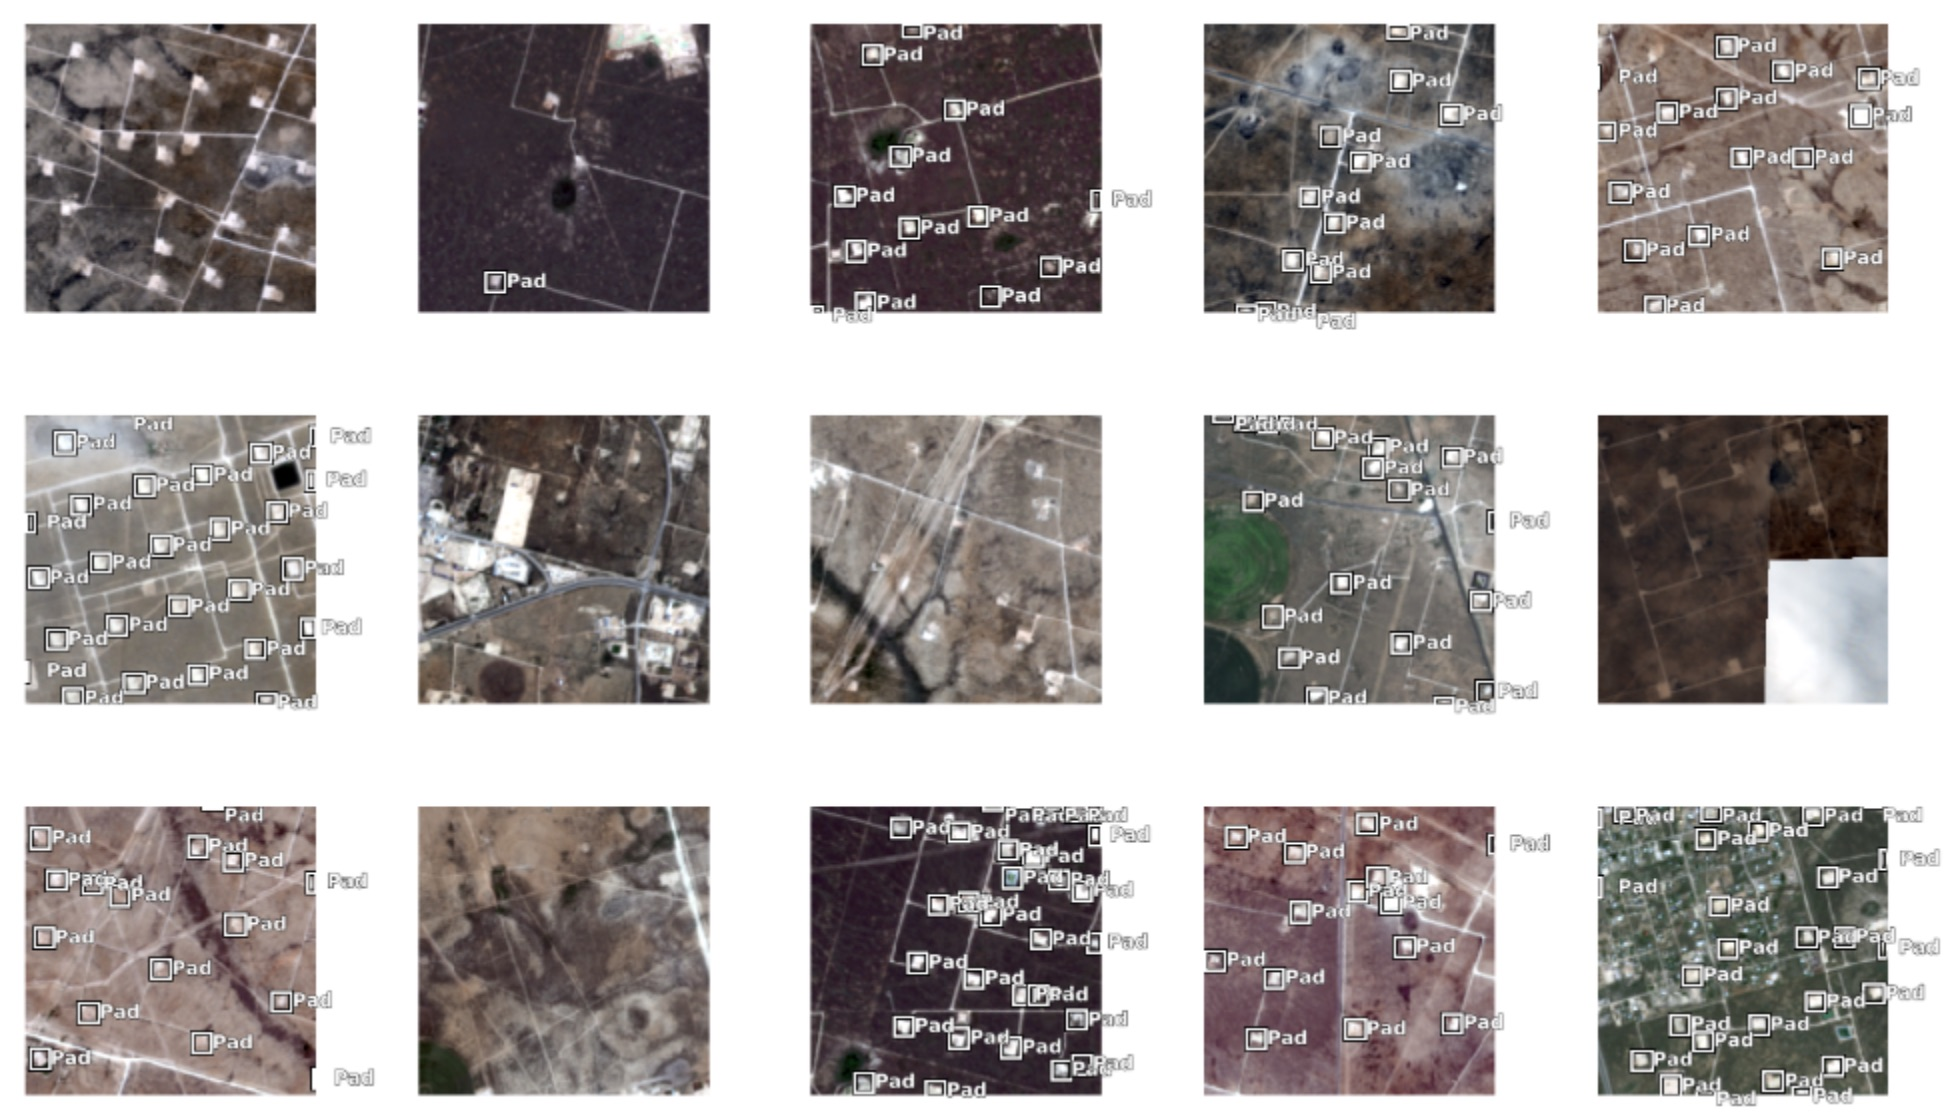

## Model Training

`arcgis.learn` includes support for training deep learning models for object detection.

The models in `arcgis.learn` are based upon pretrained Convolutional Neural Networks (CNNs, or in short, convnets) that have been trained on millions of common images such as those in the [ImageNet](http://www.image-net.org/) dataset. The intuition of a CNN is that it uses a hierarchy of layers, with the earlier layers learning to identify simple features like edges and blobs, middle layers combining these primitive features to identify corners and object parts and the later layers combining the inputs from these in unique ways to grasp what the whole image is about. The final layer in a typical convnet is a fully connected layer that looks at all the extracted features and essentially compute a weighted sum of these to determine a probability of each object class (whether its an image of a cat or a dog, etc.).

A convnet trained on a huge corpus of images such as ImageNet is thus considered as a ready-to-use feature extractor. In practive, we could replace the last layer of these convnets with something else that uses those features for other useful tasks (e.g. object detection and pixel classification), which is also called transfer learning. The advantage of transfer learning is that we now don't need as much data to train an excellent model.

The `arcgis.learn` module is based on `PyTorch` and `fast.ai` and enables fine-tuning of pretrained [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html) on satellite imagery. The `arcgis.learn` models leverages fast.ai's learning rate finder and one-cycle learning, and allows for much faster training and removes guesswork in picking hyperparameters. 

`arcgis.learn` provides the `SingleShotDetector` (SSD) model for object detection tasks, which is based on a pretrained convnet, like `ResNet` that acts as the 'backbone'. More details about SSD can be found [here]().

### Train SingleShotDetector Model

Since the image chips visualized in the section above indicate that most well pads are roughly of the same size and square in shape, we can keep an aspect ratio of 1:1 and zoom scale of 1. This will help simplify the model and make it easier to train. Also, since the size of well pads in the image chips is such that approximately nine could fit side by side, we can keep a grid size of 9.

In [21]:
from arcgis.learn import SingleShotDetector

ssd = SingleShotDetector(data, grids=[9], zooms=[1.0], ratios=[[1.0, 1.0]])

### Find the good learning rate

Now we have defined a model architecture, we can start to train it. This process involves setting a good [learning rate](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10). Picking a very small learning rate leads to very slow training of the model, while picking one that is too high can prevent the model from converging and 'overshoot' the minima where the loss (or error rate) is lowest. `arcgis.learn` includes fast.ai's learning rate finder, accessible through the model's `lr_find()` method, that helps in picking a good learning rate, without needing to experiment with several learning rates and picking from among them. 

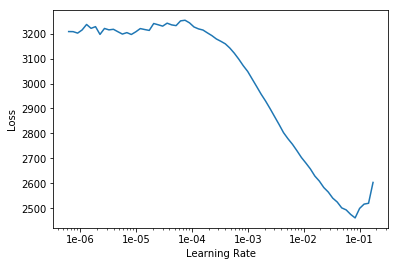

In [22]:
# The users can visualize the learning rate of the model with comparative loss.
ssd.lr_find()

In the chart above we find that the loss is going down steeply at 2e-02 (0.02) and we pick that as the max learning rate.

### Train the model

As dicussed earlier, the idea of transfer learning is to fine-tune earlier layers of the pretrained model and focus on training the newly added layers, meaning we need two different learning rates to better fit the model. We have already selected a good learning rate to train the later layers above (i.e. 0.02). An empirical value of lower learning rate for fine-tuning the ealier layers is usually one tenth of the higher rate. We choose 0.001 to be more careful not to disturb the weights of the pretrained backbone by too much. It can be adjusted depending upon how different the imagery is from natural images on which the backbone network is trained.

Training the network is an iterative process. We can train the model using its `fit()` method till the validation loss (or error rate) continues to go down with each training pass also known as epoch. This is indicative of the model learning the task. 

In [31]:
# here we are training the model for 500 epochs
ssd.fit(10, slice(0.001, 0.02))

epoch,train_loss,valid_loss
1,1743.360840,759.151855
2,1700.622559,763.675842
3,1691.474487,733.454163
4,1705.710205,736.463928
5,1715.943115,731.263000
6,1718.531738,734.463257
7,1705.809692,736.284851
8,1706.338623,738.023926
9,1707.944458,724.500916
10,1701.971069,727.411438


As each epoch progresses, the loss (error rate, that we are trying to minimize) for the training data and the validation set are reported. In the table above we can see the losses going down for both the training and validation datasets, indicating that the model is learning to recognize the well pads. We continue training the model for several iterations like this till we observe the validation loss going up. That indicates that the model is starting to overfit to the training data, and is not generalizing well enough for the validation data. When that happens, we can try adding more data (or data augmentations), increase regularization by increasing the `dropout` parameter in the SingleShotDetector model, or reduce the model complexity. 

### Unfreezing the backbone and fine-tuning

By default, the earlier layers of the model (i.e. the backbone or encoder) are frozen and their weights are not updated when the model is being trained. This allows the model to take advantage of the (ImageNet) pretrained weights for training the 'head' of the network. Once the later layers have been sufficiently trained, it helps to improve model performance and accuracy to `unfreeze()` the earlier layers and allow their weights to be fine-tuned to the nuances of the particular satellite imagery compared to the photos of everyday objects (from ImageNet) that the backbone was trained on. The learning rate finder can be used to identify the optimum lerning rate between the different training phases of the model. Please note that this step is only optional. If we don't call `unfreeze()`, the lower learning rate we specificed in the `fit()` won't be used.

### Visualize results
The results of how well the model has learnt can be visually observed using the model’s show_results() method. The ground truth is shown in the left column and the corresponding predictions from the model on the right. As we can see below, the model has learnt to detect well pads fairly well. In some cases, it is even able to detect the well pads that are missing in the ground truth data (due to inaccuracies in labelling or the records).

In [ ]:
ssd.show_results(rows=25, thresh=0.05)

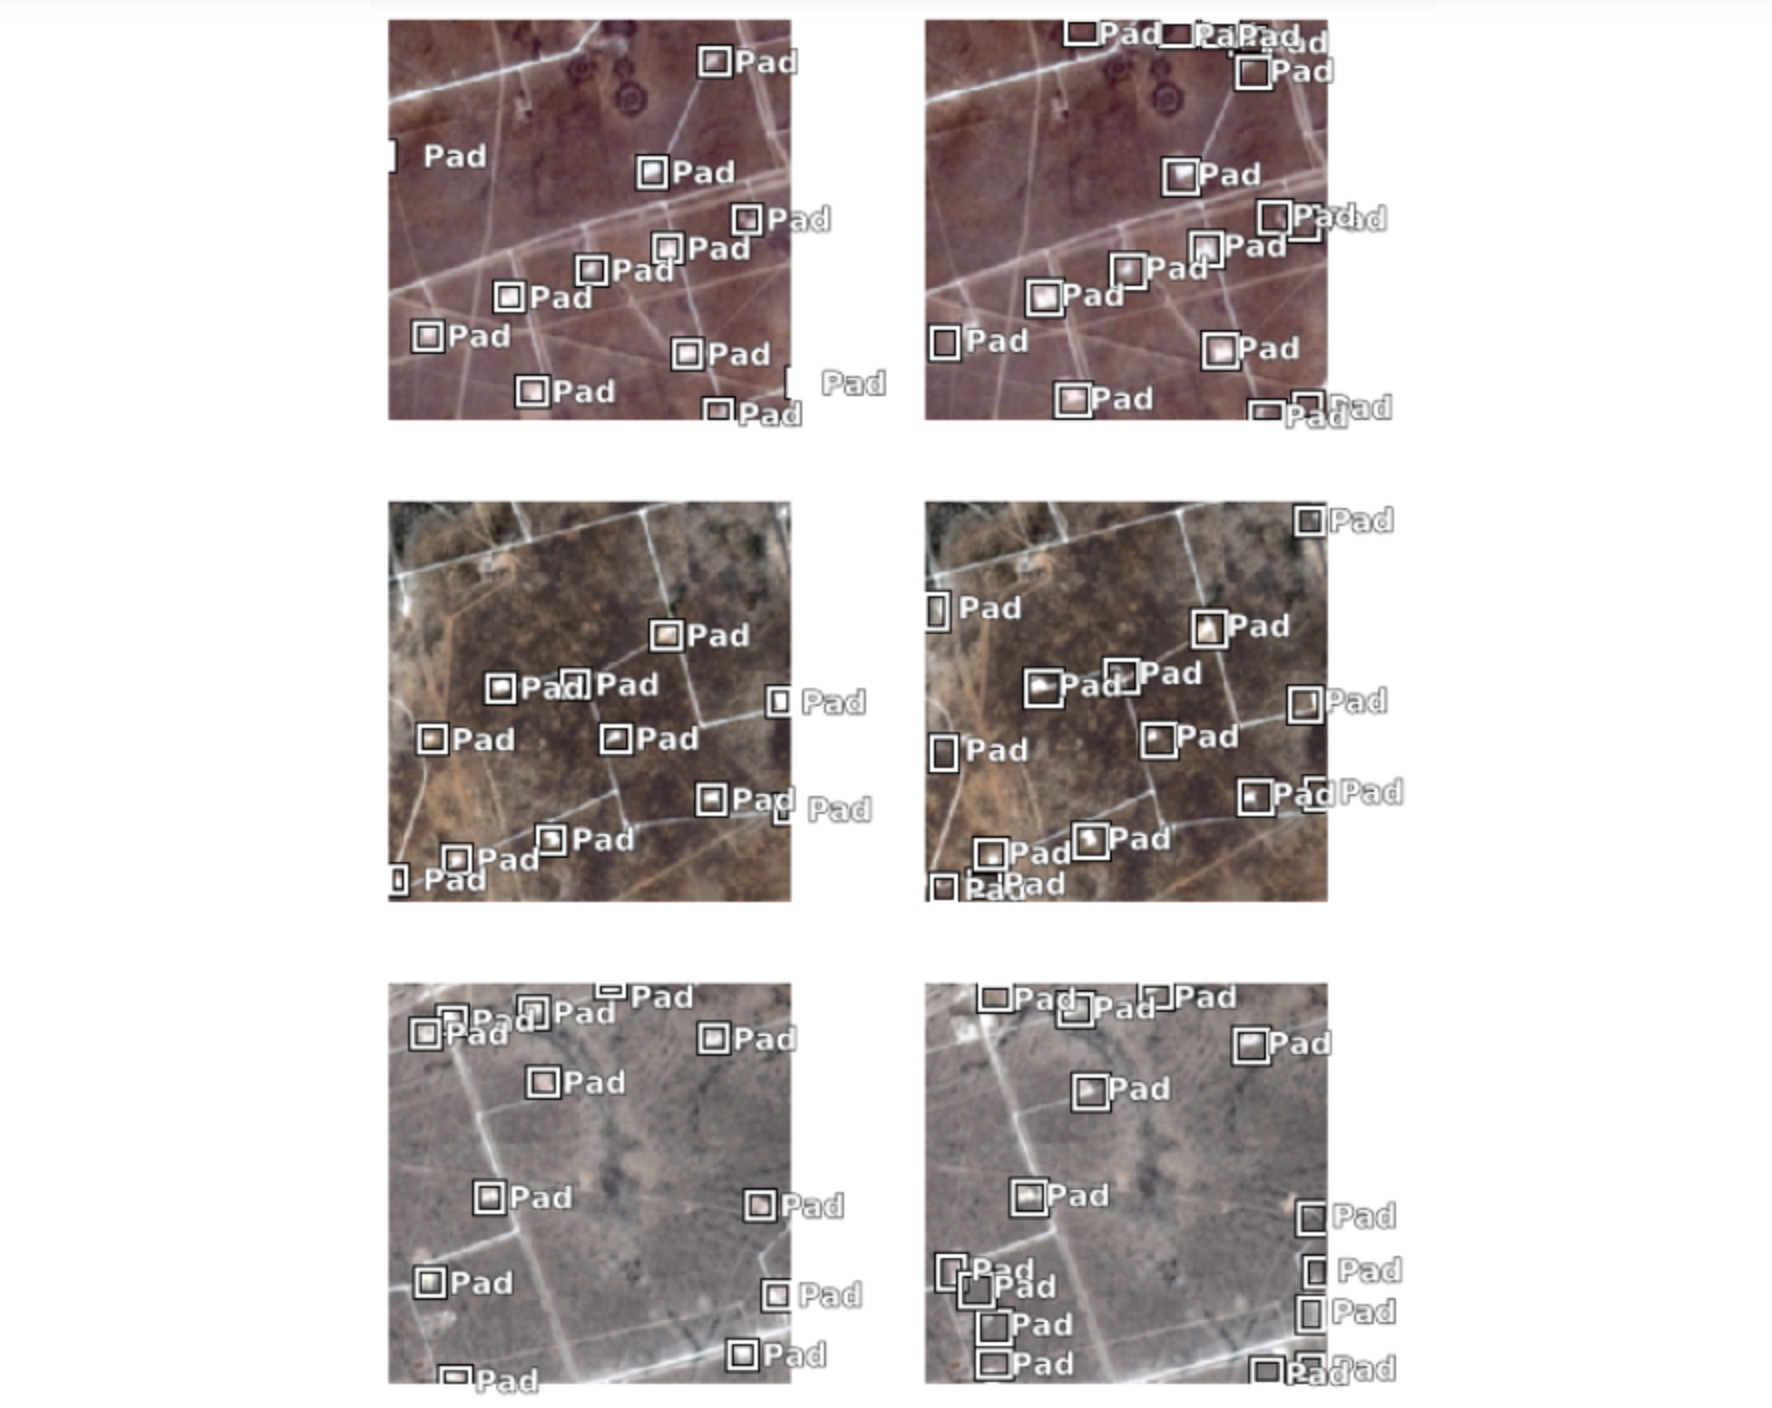

### Save and load trained models

Once you are satisfied with the model, you can save it using the `save()` method. This creates an Esri Model Definition (EMD file) that can be used for inferencing in ArcGIS Pro as well as a Deep Learning Package (DLPK zip) that can be deployed to ArcGIS Enterprise for distributed inferencing across a large geographical area using raster analytics. Saved models can also be loaded back using the `load()` method, for futher fine tuning. 

In [59]:
# save the trained model
saved_ssd = ssd.save('wellpad_model_planet_2501')

## Deploy trained model

Once a model has been trained, it can be added to ArcGIS Enterprise as a deep learning package.

In [8]:
# Upload as first class item on agol or portal as a deep learning package 
trained_model = '/arcgis/directories/rasterstore/planetdemo/models/wellpad_model_planet_2501/wellpad_model_planet_2501.zip'

In [9]:
model_package = gis.content.add(item_properties={"type":"Deep Learning Package","typeKeywords":"Deep Learning, Raster",
                                                 "title":"Well Pad Detection Model Planet 2501",
                                                 "tags":"deeplearning", 'overwrite':'True'}, data=trained_model)

In [10]:
model_package

<Item title:"Well Pad Detection Model Planet 2501" type:Deep Learning Package owner:portaladmin>

## Model management

The `arcgis.learn` module includes the `install_model()` method to install the uploaded model package (*.dlpk) to the raster analytics server.

Optionally after inferencing the necessary information from the imagery using the model, the model can be uninstalled using `uninstall_model()`. The deployed models on an Image Server can be queried using the `list_models()` method. The uploaded model package is installed automatically on first use as well. Here we are querying specific settings of the deep learning model using the model object:

In [13]:
from arcgis.learn import Model

detect_objects_model = Model(model_package)
detect_objects_model.install()
detect_objects_model.query_info()

{'Framework': 'arcgis.learn.models._inferencing',
 'ModelType': 'ObjectDetection',
 'ParameterInfo': [{'name': 'raster',
   'dataType': 'raster',
   'required': '1',
   'displayName': 'Raster',
   'description': 'Input Raster'},
  {'name': 'model',
   'dataType': 'string',
   'required': '1',
   'displayName': 'Input Model Definition (EMD) File',
   'description': 'Input model definition (EMD) JSON file'},
  {'name': 'device',
   'dataType': 'numeric',
   'required': '0',
   'displayName': 'Device ID',
   'description': 'Device ID'},
  {'name': 'padding',
   'dataType': 'numeric',
   'value': '0',
   'required': '0',
   'displayName': 'Padding',
   'description': 'Padding'},
  {'name': 'threshold',
   'dataType': 'numeric',
   'value': '0.5',
   'required': '0',
   'displayName': 'Confidence Score Threshold [0.0, 1.0]',
   'description': 'Confidence score threshold value [0.0, 1.0]'},
  {'name': 'nms_overlap',
   'dataType': 'numeric',
   'value': '0.1',
   'required': '0',
   'display

Here we can see that `threshold` and `nms_overlap` are model arguments with default value of 0.5 and 0.1 respectively. These values may be changed in detect_objects function call.

## Model inference

The `detect_objects()` function can be used to generate feature layers that contains bounding box around the detected objects in the imagery data using the specified deep learning model. 

Note that the deep learning library dependencies needs to be installed separately, in addition on the image server.

For arcgis.learn models, the following sequence of commands in ArcGIS Image Server's Pro Python environment install the necessary dependencies:

    conda install -c conda-forge spacy
    conda install -c pytorch pytorch=1.0.0 torchvision
    conda install -c fastai fastai=1.0.39
    conda install -c arcgis arcgis=1.6.0 --no-pin   

The code below shows how we can use distributed raster analytics to automate the detection of well pad for different dates, across a large geographical area and create a feature layer of well pad detections that can be used for further analysis within ArcGIS. 

In [14]:
context = {'cellSize': 10,
           'processorType':'GPU',
           'extent':{'xmin': -11392183,
                     'ymin': 3764168,
                     'xmax': -11385824,
                     'ymax': 3766079, 'spatialReference': {'latestWkid': 3857, 'wkid': 102100}}}

In [15]:
from arcgis.learn import detect_objects

detected_pads = []
input_layers = []
for i in range (3, 13, 2):
    input_layers.append(planet_mosaic_data.filter_by('Date='+str(i)))
    
for i in range(0, len(input_layers)):
    detected_pads.append(detect_objects(input_raster=input_layers[i],
                              model=detect_objects_model,
                              output_name="Well_Pad_Detection_Planet_items_2501_"+str(i),
                              context=context,
                              gis=gis))

### Visualize results

Finally, we can visualize the results using the map widget using the Python API to verify if they are as expected.


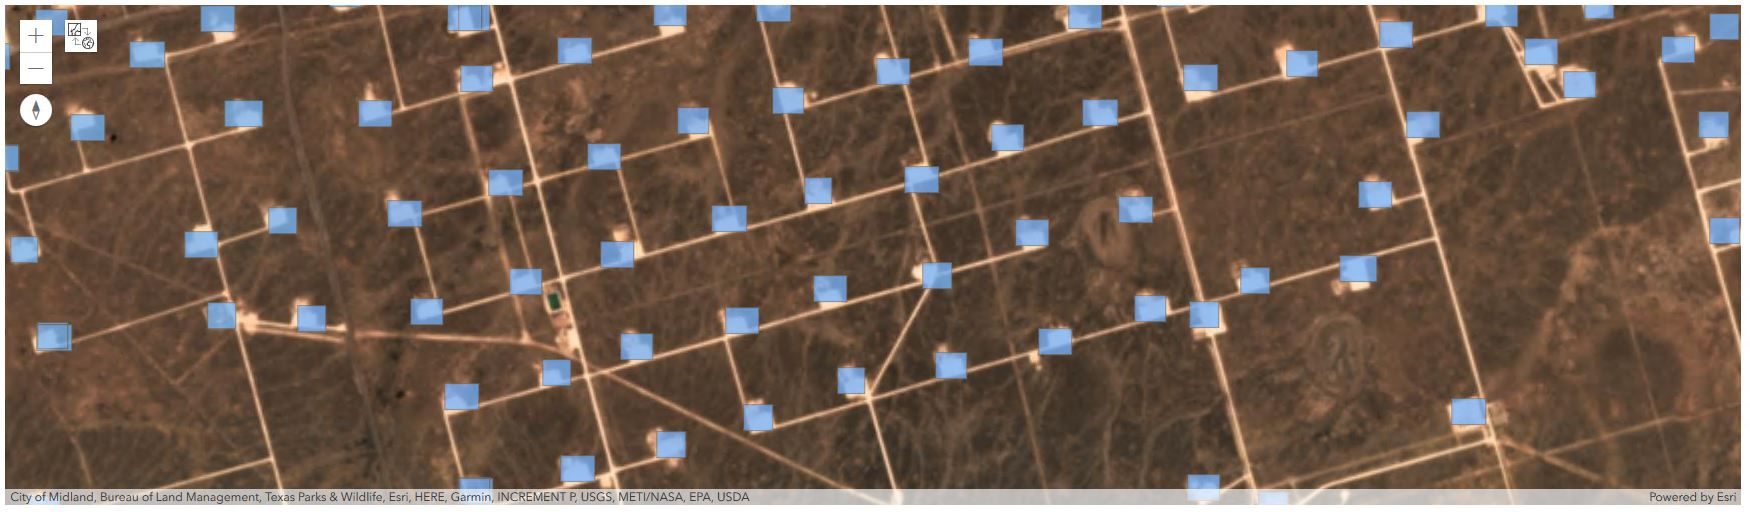

In [22]:
web_map = gis.content.search("title: Well Pad Detection 4 AND owner:portaladmin",item_type="Web Map")[0]
map_widget = gis.map(web_map)

from ipywidgets import Layout
map_widget.layout=Layout(width='100%', height='500px')

map_widget.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': -11397184.938845266,
 'ymin': 3761693.7641860787,
 'xmax': -11388891.521276105,
 'ymax': 3764082.4213200537}

map_widget.zoom = 15
map_widget